# Steps

1. ## Import SVHN dataset
2. ## Data preprocessing
   - Check data type
   - Convert to float for image and to int for label
   - Normalize the data
   - One-hot encoding for labels
   - Data augmentation
      > augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down
 
 <br>
 
 3. ## Create CNN model

 4. ## Train & Test

 5. ## Results and discussion


## PLEASE RUN FROM HERE

## Step 1: Import SVHN dataset

In [1]:
import h5py
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import numpy as np
import glob
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
# local_path = "../.." <- please change dir here
local_path = "../dataset"

## Step 2: Data Preprocessing

### 2a. Crop Images and Convert to grayscale

In [3]:
# following class are used for image crop and get cropped image path 
class CropImage(object):
    def __init__ (self, local_path, mode, grayscale=True):
        # load digitStruct.mat
        self.local_path = local_path
        self.mode = mode
        self.grayscale = grayscale
        if mode == "train":
            self.f = h5py.File(local_path + "/train/digitStruct.mat", 'r')
        elif mode == "test":
            self.f = h5py.File(local_path + "/test/digitStruct.mat", 'r')
        # get dataset for each group
        self.digitStructName = self.f['digitStruct']['name']
        self.digitStructBbox = self.f['digitStruct']['bbox']
        self.file_path_dict = {}
        
    # get bbox for each instance. bbox is a library describing the bounder box position
    def get_bbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        def bbox_helper(attr_type):
            attr = self.f[bb][attr_type]
            if len(attr) > 1:
                pos = [int(self.f[attr[j].item()][0][0]) for j in range(len(attr))]
            else:
                pos = [attr[0][0]]

            return pos
        bbox['label'] = bbox_helper('label')
        bbox['height'] = bbox_helper('height')
        bbox['left'] = bbox_helper('left')
        bbox['top'] = bbox_helper('top')
        bbox['width'] = bbox_helper('width')
        return bbox

    # get file name for each instance. File names are indexes starting from 1
    def get_name(self, n):
        name = ''.join([chr(v[0]) for v in self.f[(self.digitStructName[n][0])]])
        return name

    def save_path_to_dict(self, original_file_name, save_file_path, img):
        # save path to dict
        if original_file_name not in self.file_path_dict:
            self.file_path_dict[original_file_name] = [save_file_path]
        elif save_file_path not in self.file_path_dict[original_file_name]:
            self.file_path_dict[original_file_name].append(save_file_path)
        # save cropped image
        torchvision.utils.save_image(img, save_file_path)

    # crop image for each instance, also save cropped image name to the dict
    def crop_image(self, n):
        n_drop = 0
        # for each label, crop the image
        digit_dict = self.get_bbox(n)
        
        for label_index in range(len(digit_dict['label'])):
            label = int(digit_dict['label'][label_index])
            # label 0 is represented using 10
            if label == 10:
                label = 0

            # get crop position
            left = int(digit_dict['left'][label_index])
            upper = int(digit_dict['top'][label_index])
            right = int(left + digit_dict['width'][label_index])
            lower = int(upper + digit_dict['height'][label_index])

            # invalid data
            if left < 0 or upper < 0:
                n_drop += 1
                continue

            # crop image
            img_path_crop_test = self.local_path + '/' + self.mode + '/' + self.get_name(n)
            image = cv2.imread(img_path_crop_test)
            img = image[upper:lower, left:right, :]

            if self.grayscale == True:
                # transpose image into size 32 * 32 grayscale tensor format
                transformed_img = transforms.Compose(
                        [transforms.ToPILImage(),
                        transforms.Grayscale(num_output_channels=1),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])(img)
                # ref: http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/transforms.html
            else:
                 # If num_output_channels == 1 : returned image is single channel If num_output_channels == 3 : returned image is 3 channel with r == g == b
                transformed_img = transforms.Compose(
                        [transforms.ToPILImage(),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])(img)

            grayscale_text = 'single' if self.grayscale == True else 'rgb'
            process_folder = self.local_path + '/process/' + self.mode + '/' + grayscale_text +'/'
            # check whether the process folder exists or not
            if not os.path.exists(process_folder):
                # create a new directory because it does not exist
                os.makedirs(process_folder)
                print("Created the process folder to store preprocessed images")

            # store image as original file name + _ + label + _ + label index, saved in process folder
            original_file_name = self.get_name(n).split('.')[0]

            file_head = '_'.join([process_folder + original_file_name, str(label_index), str(label)])
            file_tail = '.png'
            inverted_file_tail = '_iv.png'

            # invert grayscale image to get a new image, by doing so we could expande our training data set
            if self.mode == "train":
                inverted_transformed_img = transforms.functional.invert(transformed_img)
                self.save_path_to_dict(original_file_name, file_head+inverted_file_tail, inverted_transformed_img)
        
            self.save_path_to_dict(original_file_name, file_head+file_tail, transformed_img)
    
    # get a list of cropped image file path
    def get_cropped_image_path(self, n):
        curr_path = self.local_path + '/' + self.mode + '/'
        # check the file name is out of range, max is 33401 for train, 13065 for test
        if n + 1 not in self.file_path_dict:
            if n + 2 >= len(os.listdir(curr_path)): # changed from 3 to 2
                print("Please check the file name!")
            else:
                # havent been processed yet
                self.crop_image(n)
        # return a list of file path name of the cropped file 
        return self.file_path_dict[str(n+1)]

In [4]:
# test functionality
# replace "local_path" to your real local path before test, e.g. "/Users/evelynhsu/CS6140"
ci_train = CropImage(local_path=local_path, mode="train", grayscale=True)
ci_train.get_cropped_image_path(33401)
ci_test = CropImage(local_path=local_path, mode="test", grayscale=False)
ci_test.get_cropped_image_path(13067)
ci_test = CropImage(local_path=local_path, mode="test", grayscale=True)
ci_test.get_cropped_image_path(13067)

Created the process folder to store preprocessed images
Created the process folder to store preprocessed images


['../dataset/process/test/single/13068_0_6.png',
 '../dataset/process/test/single/13068_1_7.png']

### 2b. Create train and test datasets

In [5]:
def get_cropped_images(cropped_img_dir_list):
    '''
    Return a list of images of a single number
    e.g. Original image = 210, return image of 2, 1, 0
    '''
    output = []
    for cropped_img_dir in cropped_img_dir_list:
        output.append(cv2.imread(cropped_img_dir))
    return output

def get_labels(data, idx, multiplier=1):
    '''
    Return a list of labels. Convert label 10 -> 0
    '''
    output = []
    for l in data.get_bbox(idx)['label']:
        output += [0] * multiplier if l == 10 else [int(l)]* multiplier
    return output

def create_input(local_path, mode): # <- possible a better function name?
    '''
    Return lists of train/test
    '''
    X, y, image_number = [], [], []
    data = CropImage(local_path, mode)
    dataset_path = local_path + "/" + mode
    total_image_num = len(glob.glob1(dataset_path, "*.png"))

    for idx in range(total_image_num):
        try:
            cropped_img_dir_list = data.get_cropped_image_path(idx)
            # Two images per number in the train, and only one in the test
            multiplier = 2 if mode == "train" else 1

            # Check if number of Cropped img == number of labels
            if len(cropped_img_dir_list) != len(
                    data.get_bbox(idx)['label'] * multiplier):
                print(
                    "Skipped {}.png, Number of cropped image is inconsistent with labels"
                    .format(idx + 1))
                continue

            X += get_cropped_images(cropped_img_dir_list)
            y += get_labels(data, idx, multiplier)
            image_number += [idx] * len(cropped_img_dir_list)

        except:
            # Failed to crop image
            print("Skipped {}.png, No cropped image output".format(idx + 1))
            continue

    return np.array(X), np.array(y), np.array(image_number)

In [14]:
# Create Train datasets ETA 38min
X_train, y_train, image_train = create_input(local_path, mode="train")
print(X_train.shape, y_train.shape)

Created the process folder to store preprocessed images
Skipped 252.png, Number of cropped image is inconsistent with labels
Skipped 724.png, Number of cropped image is inconsistent with labels
Skipped 3100.png, Number of cropped image is inconsistent with labels
Skipped 5312.png, Number of cropped image is inconsistent with labels
Skipped 6877.png, No cropped image output
Skipped 9357.png, Number of cropped image is inconsistent with labels
Skipped 11861.png, No cropped image output
Skipped 13145.png, No cropped image output
Skipped 15125.png, Number of cropped image is inconsistent with labels
Skipped 18277.png, Number of cropped image is inconsistent with labels
Skipped 18393.png, Number of cropped image is inconsistent with labels
Skipped 19383.png, Number of cropped image is inconsistent with labels
Skipped 20540.png, Number of cropped image is inconsistent with labels
Skipped 20901.png, Number of cropped image is inconsistent with labels
Skipped 20915.png, Number of cropped image

In [6]:
# Create Test datasets ETA 7min
X_test, y_test, img_number = create_input(local_path, mode="test")

Created the process folder to store preprocessed images
Skipped 344.png, No cropped image output
Skipped 439.png, Number of cropped image is inconsistent with labels
Skipped 521.png, Number of cropped image is inconsistent with labels
Skipped 2613.png, Number of cropped image is inconsistent with labels
Skipped 5260.png, Number of cropped image is inconsistent with labels
Skipped 7636.png, Number of cropped image is inconsistent with labels
Skipped 8885.png, Number of cropped image is inconsistent with labels
Skipped 12434.png, Number of cropped image is inconsistent with labels
(26016, 32, 32, 3) (26016,)


In [9]:
print(X_test.shape, y_test.shape, len(img_number))

(26016, 32, 32, 3) (26016,) 26016


## Step 3: Create CNN model

In [11]:
# Create CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten()) 
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2022-04-10 09:22:51.702450: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-10 09:22:51.738081: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe3eeb36950 executing computations on platform Host. Devices:
2022-04-10 09:22:51.738099: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


## Step 4: Train & Test

In [15]:
# ETA 11min
cnn_model.fit(X_train, y_train, epochs=10)

Train on 146394 samples
Epoch 1/10
146394/146394 [==============================] - 92s 629us/sample - loss: 0.7927 - accuracy: 0.7730
Epoch 2/10
146394/146394 [==============================] - 105s 718us/sample - loss: 0.5336 - accuracy: 0.8448
Epoch 3/10
146394/146394 [==============================] - 96s 657us/sample - loss: 0.4824 - accuracy: 0.8592
Epoch 4/10
146394/146394 [==============================] - 104s 713us/sample - loss: 0.4485 - accuracy: 0.8686
Epoch 5/10
146394/146394 [==============================] - 101s 693us/sample - loss: 0.4299 - accuracy: 0.8740
Epoch 6/10
146394/146394 [==============================] - 107s 731us/sample - loss: 0.4064 - accuracy: 0.8795
Epoch 7/10
146394/146394 [==============================] - 104s 708us/sample - loss: 0.3940 - accuracy: 0.8830
Epoch 8/10
146394/146394 [==============================] - 94s 642us/sample - loss: 0.3864 - accuracy: 0.8857
Epoch 9/10
146394/146394 [==============================] - 101s 689us/sample - los

In [16]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                147520    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [17]:
cnn_model.evaluate(X_test,y_test) # loss: 0.4989 - accuracy: 0.8708

26016/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4917467054149175, 0.8658902]

In [18]:
y_pred = cnn_model.predict_classes(X_test.astype('float64'))
print(y_pred)

[5 2 1 ... 7 6 7]


In [19]:
len(y_pred)

26016

In [21]:
#save model
cnn_model.save('./models')

INFO:tensorflow:Assets written to: ./models/assets


In [26]:
# group data by y_pred, y_test and img_number
print(y_pred.shape, y_test.shape, img_number.shape)

grouped_dict_pred = {}
grouped_dict_test = {}

for i in range(len(y_pred)):
    img = img_number[i]
    if img in grouped_dict_test:
        grouped_dict_test[img].append(y_test[i])
    else:
        grouped_dict_test[img] = [y_test[i]]
    
    if img in grouped_dict_pred:
        grouped_dict_pred[img].append(y_pred[i])
    else:
        grouped_dict_pred[img] = [y_pred[i]]

(26016,) (26016,) (26016,)


In [32]:
# count successful predicted images and calculate the accuracy
cnt = 0
for i in img_number:
    if grouped_dict_pred[i] == grouped_dict_test[i]:
        cnt += 1

#Accuracy!
acc = cnt / len(img_number)
print("Accuracy for prediction is: ", acc)

Accuracy for prediction is:  0.7590329028290282


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]


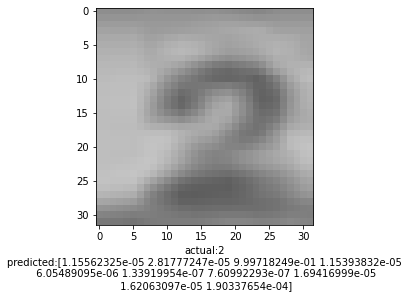

In [19]:
# Plot cropped image with predicted& actual labels
def plot_cropped_image(X, y, y_pred, idx):
    plt.imshow(X[idx])
    label = "actual:" + str(int(y[idx])) + "\npredicted:" + str(y_pred[idx])
    plt.xlabel(label)

image_index = 1
plot_cropped_image(X_test, y_test, y_pred, image_index)

In [20]:
# Plot original image with predicted& actual labels
def display_image_with_pred(cnn_model, img_index, local_path):
    mode = "test"
    data = CropImage(local_path, mode)
    img_dir = data.get_cropped_image_path(img_index - 1)
    X = get_cropped_images(img_dir)
    y = get_labels(data, img_index - 1)
    y_pred = [np.argmax(y) for y in cnn_model.predict(np.array(X))]
    
    path = local_path + "/" + mode+"/" + str(img_index) + ".png"
    plt.imshow(img.imread(path))
    
    conclusion = "Correct Prediction" if y == y_pred else "Incorrect Prediction"
    label = "actual: " + str(y) + "\npredicted: " + str(y_pred) + "\n" + conclusion
    plt.xlabel(label)

    title = "{}.png".format(img_index)
    plt.title(title)

In [21]:
img_index = 12 
display_image_with_pred(cnn_model, img_index, local_path)

TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

## Step 5: Results and discussion

### 5a. Confusion Matrix

### 5b. Feature Maps